In [16]:
import os, re, csv, json, math, warnings
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from typing import List, Tuple, Optional
from scipy.spatial import cKDTree
from skimage.filters import sato   # 或 frangi，均可
from skimage.graph import route_through_array
from skimage.morphology import skeletonize

from scipy.stats import theilslopes
warnings.filterwarnings("ignore")

# 若 apt/conda 安装的 tesseract 不在 PATH，请显式指定：
# pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"

DIGIT_CONFIG_BASE = "-c tessedit_char_whitelist=-0123456789.,"
NUM_RE = re.compile(r'^[\-\+]?[\d]+(?:[.,]\d+)?$')

def _parse_num(s: str):
    s = s.strip().replace('，',',').replace('。','.')
    s = s.replace('−','-').replace('–','-').replace('—','-')
    s = s.replace(',', '.')
    if NUM_RE.match(s):
        try: return float(s)
        except: return None
    return None

def save_csv(path, rows, header=None):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        if header: w.writerow(header)
        for r in rows: w.writerow(r)

def cv2_imread_any(path):
    path = str(path)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        data = np.fromfile(path, dtype=np.uint8)            # Unicode-safe
        img = cv2.imdecode(data, cv2.IMREAD_COLOR)
    return img

def df_to_csv_safe(df, path):
    import os, io
    os.makedirs(os.path.dirname(path), exist_ok=True)
    try:
        # 尝试常规 pandas 导出
        df.to_csv(path, index=False)
    except TypeError as e:
        # 某些环境会对 lineterminator 报错，这里兜底用纯手写
        with open(path, "w", encoding="utf-8", newline="") as f:
            # 头
            f.write(",".join(map(str, df.columns)) + "\n")
            # 行
            for row in df.itertuples(index=False, name=None):
                f.write(",".join("" if x is None else str(x) for x in row) + "\n")


def plot_img(img, title=None, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if title: plt.title(title)
    plt.axis('off'); plt.show()


In [19]:
try:
    import torch
    from transformers import Pix2StructForConditionalGeneration, Pix2StructProcessor
    _DEPLOT_OK = True
except Exception as e:
    print("DePlot 模块不可用，将在运行时自动回退到 OCR 方案。", e)
    _DEPLOT_OK = False

class DePlotWrapper:
    def __init__(self, model_id: str = "google/deplot"):
        if not _DEPLOT_OK:
            self.model = None
            self.processor = None
            return
        try:
            self.processor = Pix2StructProcessor.from_pretrained(model_id)
            self.model = Pix2StructForConditionalGeneration.from_pretrained(model_id)
            self.model.eval()
        except Exception as e:
            print("加载 DePlot 失败，将回退到 OCR 方案。", e)
            self.model = None
            self.processor = None

    def available(self):
        return (self.model is not None) and (self.processor is not None)

    '''
    def infer_table(self, img_bgr):
        """返回 DataFrame；失败返回 None。"""
        if not self.available():
            return None
        from PIL import Image
        import pandas as pd
        import numpy as np

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        pil = Image.fromarray(img_rgb)
        prompt = "Generate the underlying data table of the figure below:"

        with torch.no_grad():
            inputs = self.processor(images=pil, text=prompt, return_tensors="pt")
            outputs = self.model.generate(**inputs, max_new_tokens=512)
            txt = self.processor.decode(outputs[0], skip_special_tokens=True)

        # 解析 markdown/CSV 风格结果
        lines = [l.strip() for l in txt.splitlines() if l.strip()]
        rows = []
        for ln in lines:
            if "|" in ln:
                cols = [c.strip() for c in ln.strip("|").split("|")]
                rows.append(cols)
            elif "," in ln:
                rows.append([c.strip() for c in ln.split(",")])

        if not rows:
            return None

        header = [c if c else f"col{i}" for i, c in enumerate(rows[0])]
        data = [r for r in rows[1:] if len(r) == len(header)]
        if not data:
            return None

        df = pd.DataFrame(data, columns=header)
        # 尝试转数值
        for col in df.columns:
            try:
                df[col] = df[col].map(lambda s: _parse_num(str(s)))
            except Exception:
                pass
        return df
    '''

    # —— 直接替换 DePlotWrapper 里的 infer_table 方法 —— 
    def infer_table(self, img_bgr, axis_hint=("x","z"), debug_save_txt=None):
        """
        尝试多提示词和更鲁棒的解析。
        axis_hint=("x","z") 表示横轴名字和纵轴名字，仅用于提示，不影响返回顺序。
        返回: DataFrame 或 None；如 debug_save_txt 传路径，会把原始生成文本落盘。
        """
        if not self.available():
            return None

        from PIL import Image
        import torch, re, pandas as pd, numpy as np

        # 1) 只喂“绘图区”给模型（减少干扰）
        roi = find_plot_roi(img_bgr)
        x0,y0,x1,y1 = roi
        crop = img_bgr[y0:y1, x0:x1]
        img_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
        pil = Image.fromarray(img_rgb)

        # 2) 多提示词重试（从“只要CSV”到“允许 Markdown 表”逐步放松）
        prompts = [
            f"Return ONLY CSV with two numeric columns: {axis_hint[0]}, {axis_hint[1]}. No headers, no text, one pair per line.",
            f"Output comma-separated numeric pairs ({axis_hint[0]}, {axis_hint[1]}), one per line. No extra text.",
            f"Generate the underlying data table of the figure below. Use CSV or Markdown table with numeric values only.",
        ]

        txt_raw = None
        for i, prompt in enumerate(prompts):
            try:
                with torch.no_grad():
                    inputs = self.processor(
                        images=pil, text=prompt, return_tensors="pt", max_patches=1024
                    )
                    outputs = self.model.generate(
                        **inputs,
                        max_new_tokens=1024,
                        num_beams=3,
                        early_stopping=True,
                        no_repeat_ngram_size=3,
                        length_penalty=0.1,
                    )
                    txt_raw = self.processor.decode(outputs[0], skip_special_tokens=True)
                # 解析
                df = _parse_deplot_text_to_df(txt_raw)
                if isinstance(df, pd.DataFrame) and df.shape[1] >= 2:
                    # 只取前两列，且保持“第1列= X/Y、第2列= Z”的约定
                    v = pd.to_numeric(df.iloc[:,0], errors="coerce")
                    z = pd.to_numeric(df.iloc[:,1], errors="coerce")
                    good = (~v.isna()) & (~z.isna())
                    if good.sum() >= 10:
                        out = pd.DataFrame({"z": z[good].values, axis_hint[0]: v[good].values})
                        # 排序、去重（按 z）
                        order = np.argsort(out["z"].values)
                        out = out.iloc[order]
                        out = out.drop_duplicates(subset=["z"], keep="first")
                        if debug_save_txt:
                            os.makedirs(os.path.dirname(debug_save_txt), exist_ok=True)
                            with open(debug_save_txt, "w", encoding="utf-8") as f:
                                f.write(txt_raw)
                        # 返回成你外层需要的两列顺序（["z", "x"] 或 ["z", "y"]）
                        return out[["z", axis_hint[0]]]
            except Exception as e:
                # 当前提示失败就换下一个
                continue

        # 全部提示都没成功解析：返回 None，让上层自动回退到 OCR
        if debug_save_txt and txt_raw is not None:
            os.makedirs(os.path.dirname(debug_save_txt), exist_ok=True)
            with open(debug_save_txt, "w", encoding="utf-8") as f:
                f.write(txt_raw)
        return None

    @staticmethod 
    def _parse_deplot_text_to_df(txt: str):
        """
        兼容三类输出：
        1) 纯 CSV（每行两个数）
        2) Markdown 表（'| a | b |'）
        3) 混合文本里散落的数字对（正则兜底）
        返回: pandas.DataFrame 或 None
        """
        import pandas as pd, re
        if not txt or not isinstance(txt, str) or not txt.strip():
            return None

        lines = [l.strip() for l in txt.splitlines() if l.strip()]
        rows = []

        # A) Markdown 表
        md_rows = []
        for ln in lines:
            if "|" in ln:
                cols = [c.strip() for c in ln.strip("|").split("|")]
                # 过滤掉 '---' 这种分隔行
                if any(set(c) == {"-"} for c in cols):
                    continue
                md_rows.append(cols)
        if md_rows:
            # 去掉可能的表头
            if not _row_is_numeric(md_rows[0]):
                md_rows = md_rows[1:]
            md_rows = [r for r in md_rows if _row_is_numeric(r)]
            if md_rows:
                return pd.DataFrame(md_rows)

        # B) 纯 CSV（逗号/分号/空格）
        csv_rows = []
        for ln in lines:
            if "," in ln or ";" in ln:
                parts = re.split(r"[;,]", ln)
                parts = [p.strip() for p in parts if p.strip()]
                if len(parts) >= 2 and _row_is_numeric(parts[:2]):
                    csv_rows.append(parts[:2])
            else:
                # 允许用空格分隔
                parts = ln.split()
                if len(parts) >= 2 and _row_is_numeric(parts[:2]):
                    csv_rows.append(parts[:2])
        if csv_rows:
            return pd.DataFrame(csv_rows)

        # C) 正则兜底：抓每行里的“两个数”
        reg_rows = []
        num = r"[+\-]?\d+(?:\.\d+)?"
        for ln in lines:
            m = re.findall(num, ln)
            if len(m) >= 2:
                reg_rows.append(m[:2])
        if reg_rows:
            return pd.DataFrame(reg_rows)

        return None

    @staticmethod
    def _row_is_numeric(it):
        import math
        try:
            a = float(str(it[0]).replace(",", "."))
            b = float(str(it[1]).replace(",", "."))
            return math.isfinite(a) and math.isfinite(b)
        except:
            return False


DePlot 模块不可用，将在运行时自动回退到 OCR 方案。 No module named 'transformers'


In [20]:
def find_plot_roi(img, fallback_margin=0.05):
    h, w = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ed = cv2.Canny(gray, 60, 160)
    ed = cv2.dilate(ed, np.ones((3,3),np.uint8), 1)
    cnts, _ = cv2.findContours(ed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    best, best_area = None, 0
    for c in cnts:
        x,y,wc,hc = cv2.boundingRect(c)
        area = wc*hc
        if 0.25*h*w < area < 0.98*h*w and area > best_area:
            best_area, best = area, (x,y,x+wc,y+hc)
    if best is None:
        m = int(fallback_margin*min(h,w))
        return (m,m,w-m,h-m)
    return best

def _skeletonize(bin_u8):
    sk = skeletonize((bin_u8>0).astype(bool))
    return (sk.astype(np.uint8)*255)


def extract_curve_points(img_bgr, roi=None, color_hint=None):
    if roi is None: roi = find_plot_roi(img_bgr)
    x0,y0,x1,y1 = roi
    crop = img_bgr[y0:y1, x0:x1]
    lab = cv2.cvtColor(crop, cv2.COLOR_BGR2LAB)
    L,A,B = cv2.split(lab)
    chroma = np.sqrt((A-128.0)**2 + (B-128.0)**2)
    hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
    V = hsv[:,:,2]
    c_thr = np.percentile(chroma, 99) * 0.35
    v_thr = np.percentile(V, 75) * 0.7
    mask = (chroma>c_thr) & (V>v_thr)
    if color_hint in ('red','blue','green'):
        H,S,Val = cv2.split(hsv)
        if color_hint=='red':
            hint = ((H<10)|(H>170))&(S>50)&(Val>50)
        elif color_hint=='blue':
            hint = (H>90)&(H<140)&(S>50)&(Val>50)
        else:
            hint = (H>35)&(H<85)&(S>50)&(Val>50)
        mask = mask | hint
    bin_u8 = (mask.astype(np.uint8)*255)
    bin_u8 = cv2.morphologyEx(bin_u8, cv2.MORPH_OPEN, np.ones((3,3),np.uint8), 1)
    bin_u8 = cv2.morphologyEx(bin_u8, cv2.MORPH_DILATE, np.ones((3,3),np.uint8), 1)

    # 兜底：主色相 + Canny
    ys,xs = np.where(bin_u8>0)
    if len(xs)<50:
        H,S,Val = cv2.split(hsv)
        topk = np.argsort(chroma.ravel())[-max(1000, chroma.size//20):]
        hue_peak = np.bincount(H.ravel()[topk], minlength=181).argmax()
        lower = np.array([max(hue_peak-10,0), 30, 50])
        upper = np.array([min(hue_peak+10,180), 255, 255])
        mask2 = cv2.inRange(hsv, lower, upper)
        mask2 = cv2.morphologyEx(mask2, cv2.MORPH_OPEN, np.ones((3,3),np.uint8), 1)
        mask2 = cv2.GaussianBlur(mask2, (3,3), 0)
        edges = cv2.Canny(mask2, 30, 80)
        bin_u8 = edges
    bin_u8 = _largest_component(bin_u8)
    bin_u8 = _skeletonize(bin_u8)
    path = _longest_path_on_skeleton(bin_u8)
    if len(path)==0: return path, roi
    path[:,0] += x0; path[:,1] += y0
    return path, roi

def save_overlay(path, img, roi, pts):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    vis = img.copy()
    step = max(1, len(pts)//1500) if len(pts)>0 else 1
    for (px,py) in pts[::step]:
        cv2.circle(vis, (int(px), int(py)), 1, (0,255,0), -1)
    x0,y0,x1,y1 = roi
    cv2.rectangle(vis, (x0,y0), (x1,y1), (0,255,255), 2)
    cv2.imwrite(path, vis)


In [21]:
import numpy as np, cv2
from collections import deque
from scipy.stats import theilslopes

# --- ROI 稍微外扩，避免线贴边被切掉 ---
def _pad_roi(roi, img_shape, pad=4):
    x0,y0,x1,y1 = roi
    H,W = img_shape[:2]
    return max(0,x0-pad), max(0,y0-pad), min(W,x1+pad), min(H,y1+pad)

# --- 去网格：提取水平/竖直长线并减掉，再做边缘 ---
def _remove_grid(gray):
    hor = cv2.morphologyEx(gray, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT,(31,1)))
    ver = cv2.morphologyEx(gray, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT,(1,31)))
    grid = cv2.max(hor, ver)
    base = cv2.subtract(gray, grid)
    base = cv2.GaussianBlur(base, (3,3), 0)
    return base

# --- 自动找 hue 峰（高饱和高亮区域） ---
def _peak_hues(hsv, sat_thr=60, val_thr=50, topk=3):
    H,S,V = cv2.split(hsv)
    mask = (S>=sat_thr) & (V>=val_thr)
    if np.count_nonzero(mask) < 200: return []
    hist,_ = np.histogram(H[mask], bins=181, range=(0,181))
    hist = cv2.GaussianBlur(hist.astype(np.float32).reshape(-1,1),(5,1),0).ravel()
    peaks = hist.argsort()[::-1][:topk]
    # 合并到大色系（红色回绕单独处理）
    out=[]; seen=set()
    for h in peaks:
        if h<10 or h>170: name="red"
        elif 35<=h<=85: name="green"
        elif 90<=h<=140: name="blue"
        else: name="other"
        if name not in seen:
            seen.add(name); out.append((name,int(h)))
    return out

def _mask_from_hue(hsv, h_center, band=12, s_min=60, v_min=50):
    if h_center < band:
        m1 = cv2.inRange(hsv, (0, s_min, v_min), (h_center+band,255,255))
        m2 = cv2.inRange(hsv, (180-(band-h_center), s_min, v_min), (180,255,255))
        return cv2.bitwise_or(m1,m2)
    if h_center+band>180:
        m1 = cv2.inRange(hsv, (0, s_min, v_min), ((h_center+band)-180,255,255))
        m2 = cv2.inRange(hsv, (h_center-band, s_min, v_min), (180,255,255))
        return cv2.bitwise_or(m1,m2)
    return cv2.inRange(hsv, (h_center-band, s_min, v_min), (h_center+band,255,255))

# --- 最大连通域 ---
def _largest_component(mask, min_keep=150):
    """
    输入: mask 可为 bool 或 uint8(0/255)。
    输出: uint8 0/255，且仅保留最大连通域（若最大域太小则原样返回）。
    """
    m = mask
    if m.dtype != np.uint8:
        m = (m > 0).astype(np.uint8)
    # 统一成 0/255，后续形态学/可视化更稳
    if m.max() == 1:
        m = m * 255

    num, labels, stats, _ = cv2.connectedComponentsWithStats(m, connectivity=8)
    if num <= 1:
        return m

    # 找面积最大（跳过背景0）
    idx = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    if stats[idx, cv2.CC_STAT_AREA] < min_keep:
        return m

    out = np.zeros_like(m)
    out[labels == idx] = 255
    return out


# --- 骨架（首选 ximgproc.thinning，兜底 Zhang-Suen） ---
def _skeletonize(bin255):
    bin255 = (bin255>0).astype(np.uint8)*255
    try:
        import cv2.ximgproc as xi
        return xi.thinning(bin255)  # 返回0/255
    except Exception:
        # Zhang-Suen 简化实现
        img = (bin255>0).astype(np.uint8)
        changed = True
        while changed:
            changed=False
            to0=[]
            H,W = img.shape
            for step in (0,1):
                for y in range(1,H-1):
                    for x in range(1,W-1):
                        if img[y,x]==0: continue
                        P = [img[y-1,x],img[y-1,x+1],img[y,x+1],img[y+1,x+1],
                             img[y+1,x],img[y+1,x-1],img[y,x-1],img[y-1,x-1]]
                        nz = sum(p>0 for p in P)
                        if nz<2 or nz>6: continue
                        # 0->1 转换次数
                        trans = 0
                        for i in range(8):
                            if P[i]==0 and P[(i+1)%8]>0: trans += 1
                        if trans != 1: continue
                        if step==0:
                            if P[0]*P[2]*P[4]>0: continue
                            if P[2]*P[4]*P[6]>0: continue
                        else:
                            if P[0]*P[2]*P[6]>0: continue
                            if P[0]*P[4]*P[6]>0: continue
                        to0.append((y,x))
                if to0:
                    for (yy,xx) in to0: img[yy,xx]=0
                    changed=True
                    to0=[]
        return img*255

# --- 取骨架端点 ---
def _skeleton_endpoints(skel255):
    sk = (skel255>0).astype(np.uint8)
    ys,xs = np.where(sk>0)
    pts = list(zip(xs,ys))
    s = set(pts)
    ends=[]
    for x,y in pts:
        cnt=0
        for dx in (-1,0,1):
            for dy in (-1,0,1):
                if dx==0 and dy==0: continue
                if (x+dx,y+dy) in s: cnt+=1
        if cnt==1: ends.append((x,y))
    return ends

# --- 连接近端点（补断裂） ---
def _connect_close_endpoints(skel255, max_gap):
    sk = (skel255>0).astype(np.uint8)*255
    ends = _skeleton_endpoints(sk)
    if len(ends)<2: return sk
    used=set()
    for i in range(len(ends)):
        if i in used: continue
        xi,yi = ends[i]
        best=None; bestd=1e9; bestj=None
        for j in range(i+1,len(ends)):
            if j in used: continue
            xj,yj = ends[j]
            d = np.hypot(xi-xj, yi-yj)
            if d<bestd:
                bestd=d; bestj=j
        if bestd<=max_gap and bestj is not None:
            cv2.line(sk, (xi,yi), ends[bestj], 255, 1, cv2.LINE_8)
            used.add(i); used.add(bestj)
    return sk

# --- 从骨架取最长路径（像素级） ---
def _longest_path_on_skeleton(skel255):
    sk = (skel255>0).astype(np.uint8)
    ys,xs = np.where(sk>0)
    if len(xs)==0: return np.empty((0,2),dtype=int)
    pts = list(zip(xs,ys))
    idx = {p:i for i,p in enumerate(pts)}
    # 建图
    nbrs=[[] for _ in pts]
    for k,(x,y) in enumerate(pts):
        for dx in (-1,0,1):
            for dy in (-1,0,1):
                if dx==0 and dy==0: continue
                q=(x+dx,y+dy)
                j=idx.get(q)
                if j is not None: nbrs[k].append(j)
    # 找端点，否则做“直径”双 BFS
    deg = [len(n) for n in nbrs]
    endpoints = [i for i,d in enumerate(deg) if d==1]
    def bfs(start):
        q=deque([start]); dist={start:0}; parent={start:-1}
        last=start
        while q:
            u=q.popleft(); last=u
            for v in nbrs[u]:
                if v in dist: continue
                dist[v]=dist[u]+1; parent[v]=u; q.append(v)
        return last, dist, parent
    if endpoints:
        a=endpoints[0]
    else:
        a=0
    b,_,par = bfs(a)
    c,_,par2= bfs(b)
    # 回溯 b->c 路径
    path=[]
    u=c
    while u!=-1:
        path.append(pts[u]); u=par2.get(u,-1)
    return np.array(path, dtype=int)

def _kill_border(u8, px=6):
    """把靠边 px 像素都置 0，杀掉内框/坐标轴"""
    m = u8.copy()
    if m.ndim == 3:  # 保护一下三通道
        m = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)
    H, W = m.shape
    if px > 0:
        m[:px, :] = 0; m[-px:, :] = 0; m[:, :px] = 0; m[:, -px:] = 0
    return m


def _component_touches_border(comp255, px=4, frac=0.25):
    M = comp255 > 0
    H, W = M.shape
    border = np.zeros_like(M, bool)
    border[:px,:] = True; border[-px:,:] = True; border[:,:px] = True; border[:,-px:] = True
    touch = (M & border).sum()
    area  = M.sum()
    return area > 0 and (touch / max(area,1)) > frac

def _border_penalty(shape, px=6):
    H, W = shape
    yy = np.minimum(np.arange(H), np.arange(H)[::-1])[:,None]
    xx = np.minimum(np.arange(W), np.arange(W)[::-1])[None,:]
    d = np.minimum(yy, xx).astype(np.float32)
    return (px - np.clip(d, 0, px)) / max(px,1)  # 边缘=1, 内部=0

# ---- 新增：骨架剪枝（去掉短枝）----
def _prune_skeleton(skel255, min_len=20):
    sk = (skel255>0).astype(np.uint8)
    H,W = sk.shape
    changed = True
    while changed:
        changed = False
        ys, xs = np.where(sk>0)
        for y,x in zip(ys, xs):
            # 统计8邻域
            cnt = 0
            nbr = []
            for dy in (-1,0,1):
                for dx in (-1,0,1):
                    if dx==0 and dy==0: continue
                    yy,xx = y+dy, x+dx
                    if 0<=yy<H and 0<=xx<W and sk[yy,xx]>0:
                        cnt += 1; nbr.append((yy,xx))
            if cnt==1:
                # 从这个端点往前走，若很短就剪掉
                path = [(y,x)]
                py, px = y, x
                for _ in range(min_len):
                    # 找唯一的下一点
                    nxt = []
                    for dy in (-1,0,1):
                        for dx in (-1,0,1):
                            if dx==0 and dy==0: continue
                            yy,xx = py+dy, px+dx
                            if 0<=yy<H and 0<=xx<W and sk[yy,xx]>0 and (yy,xx) not in path:
                                nxt.append((yy,xx))
                    if len(nxt)!=1: break
                    py,px = nxt[0]
                    path.append((py,px))
                if len(path) < min_len:
                    for yy,xx in path: sk[yy,xx]=0
                    changed = True
    return sk*255

# 2) 新增：计算“贴边比例”（用于评分惩罚）
def _border_touch_ratio(path_rc, H, W, thr=3):
    xs, ys = path_rc[:,1], path_rc[:,0]   # path_rc 是 (y,x)
    hit = ((xs < thr) | (xs > W - 1 - thr) | (ys < thr) | (ys > H - 1 - thr)).sum()
    return hit / max(1, len(path_rc))

# 3) 修改评分：对贴边路径降权；对颜色候选加成
def _score_path(path_rc, H, W, kind="edge"):
    if len(path_rc) < 20: 
        return 0.0
    p = path_rc[:, ::-1].astype(np.float32)      # (y,x) -> (x,y) 仅用于差分
    diff = np.diff(p, axis=0)
    length = np.sum(np.linalg.norm(diff, axis=1))
    span = (p[:,0].max() - p[:,0].min()) + (p[:,1].max() - p[:,1].min())
    d2 = np.diff(p, n=2, axis=0)
    smooth = 1.0 / (np.mean(np.linalg.norm(d2, axis=1)) + 1e-3)

    base = 0.6*length + 0.3*span + 0.1*smooth

    # 贴边惩罚（矩形外框会有很高贴边率）
    touch = _border_touch_ratio(path_rc, H, W, thr=3)
    base *= (1.0 - min(0.85, 0.9 * touch))   # 最多压到 15%

    # 颜色候选的小加成（有 hue 时优先 hue）
    if kind == "hue":
        base *= 1.15

    return base


def _norm01(a):
    a = a.astype(np.float32)
    mn, mx = a.min(), a.max()
    return (a - mn) / (mx - mn + 1e-8)

def _build_cost_image(crop_bgr, hue_center=None):
    # 1) 线结构增强（对细长亮线特别友好）
    gray = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2GRAY)
    vessel = sato(_norm01(gray), sigmas=tuple(range(1, 5)))   # 细到粗的多尺度
    vessel_n = _norm01(vessel)

    # 2) 可选颜色相似度（自动抓主色相，不强制指定）
    cost = 1.0 - vessel_n   # vessel 强 => cost 低
    if hue_center is not None:
        hsv = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2HSV)
        H, S, V = cv2.split(hsv)
        # 色相圆距离（0~1），饱和度越高越可信
        d = np.minimum(np.abs(H - hue_center), 180 - np.abs(H - hue_center)) / 90.0
        color_penalty = _norm01(d) * (1.0 - _norm01(S)) * 0.5
        cost = _norm01(cost + color_penalty)

    # 3) 加一点常数避免 0 权重
    return _norm01(cost) + 1e-3

def _pick_hue_center(crop_bgr):
    hsv = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv)
    mask = (S >= 60) & (V >= 50)
    if np.count_nonzero(mask) < 200:
        return None
    hist, _ = np.histogram(H[mask], bins=181, range=(0,181))
    h = int(hist.argmax())
    return h

def _farthest_pair_on_mask(mask255):
    # 取骨架后“直径”两端作为端点
    from collections import deque
    sk = (mask255 > 0).astype(np.uint8)
    ys, xs = np.where(sk)
    if len(xs) == 0: return None, None
    pts = list(zip(xs, ys))
    idx = {p:i for i,p in enumerate(pts)}
    nbrs = [[] for _ in pts]
    for k,(x,y) in enumerate(pts):
        for dx in (-1,0,1):
            for dy in (-1,0,1):
                if dx==0 and dy==0: continue
                q=(x+dx,y+dy); j=idx.get(q)
                if j is not None: nbrs[k].append(j)
    def bfs(start):
        q = deque([start]); dist={start:0}; parent={start:-1}; last=start
        while q:
            u=q.popleft(); last=u
            for v in nbrs[u]:
                if v in dist: continue
                dist[v]=dist[u]+1; parent[v]=u; q.append(v)
        return last, dist, parent
    a = 0
    b,_,_  = bfs(a)
    c,_,p2 = bfs(b)
    # 回溯 b->c
    path=[]; u=c
    while u!=-1:
        path.append(pts[u]); u=p2.get(u,-1)
    return path[0], path[-1]   # 两端点 (x,y)

def extract_curve_points_full(img_bgr, roi, max_gap_pct=0.06, debug=False):
    """
    颜色无先验：多候选 + 去网格 + 骨架 + 测地最短路，拿到整段曲线
    返回：按路径排序的像素坐标 (N,2)，全局坐标
    """
    x0,y0,x1,y1 = roi
    crop = img_bgr[y0:y1, x0:x1]

    # ——(A) 先做一个“粗分割”得到若干候选——
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    # 去掉网格与坐标轴
    hor = cv2.morphologyEx(gray, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT,(31,1)))
    ver = cv2.morphologyEx(gray, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT,(1,31)))
    base = cv2.subtract(gray, cv2.max(hor, ver))
    base = cv2.GaussianBlur(base, (3,3), 0)

    hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
    L,A,B = cv2.split(cv2.cvtColor(crop, cv2.COLOR_BGR2LAB))
    chroma = np.sqrt((A-128.0)**2 + (B-128.0)**2)

    # 色度+亮度
    c_thr = np.percentile(chroma, 99)*0.30
    v_thr = np.percentile(hsv[:,:,2], 75)*0.65
    m_ch  = ((chroma>c_thr) & (hsv[:,:,2]>v_thr)).astype(np.uint8)*255
    m_ch  = cv2.morphologyEx(m_ch, cv2.MORPH_OPEN,  np.ones((3,3),np.uint8), 1)
    m_ch  = cv2.morphologyEx(m_ch, cv2.MORPH_DILATE, np.ones((3,3),np.uint8), 1)

    # 色相峰（自动挑主色）
    h0 = _pick_hue_center(crop)
    if h0 is not None:
        def _mask_h(hc):
            band=14
            if hc < band:
                m1 = cv2.inRange(hsv,(0,60,50),(hc+band,255,255))
                m2 = cv2.inRange(hsv,(180-(band-hc),60,50),(180,255,255))
                return cv2.bitwise_or(m1,m2)
            if hc+band>180:
                m1 = cv2.inRange(hsv,(0,60,50),((hc+band)-180,255,255))
                m2 = cv2.inRange(hsv,(hc-band,60,50),(180,255,255))
                return cv2.bitwise_or(m1,m2)
            return cv2.inRange(hsv,(hc-band,60,50),(hc+band,255,255))
        m_h  = _mask_h(h0)
    else:
        m_h  = np.zeros_like(m_ch)

    # Canny 作兜底
    edges = cv2.Canny(base, 40, 100)

    # 综合候选
    mask0 = cv2.bitwise_or(m_ch, m_h)
    mask0 = cv2.bitwise_or(mask0, edges)
    mask0 = (mask0>0).astype(np.uint8)*255

    # 👉(1) 杀边 & 贴边连通域过滤
    mask0 = _kill_border(mask0, px=6)
    num, lab, stats, _ = cv2.connectedComponentsWithStats(mask0, connectivity=8)
    keep = np.zeros_like(mask0, np.uint8)
    for i in range(1, num):
        if stats[i, cv2.CC_STAT_AREA] < 150:  # 小噪点
            continue
        comp = (lab==i).astype(np.uint8)*255
        if _component_touches_border(comp, px=4, frac=0.25):
            continue
        keep = cv2.bitwise_or(keep, comp)
    mask = keep if keep.any() else mask0
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5),np.uint8), 1)

    # 👉(2) 骨架 + 剪枝（避免短枝当端点）
    try:
        import cv2.ximgproc as xi
        skel = xi.thinning(mask)
    except Exception:
        from skimage.morphology import skeletonize
        skel = (skeletonize((mask>0).astype(bool)).astype(np.uint8)*255)
    skel = _prune_skeleton(skel, min_len=max(18, int(0.02*min(mask.shape))))
    
    pA, pB = _farthest_pair_on_mask(skel)   # 你的函数不变
    if pA is None or pB is None:
        return np.empty((0,2), dtype=int)

    # 👉(3) “走廊约束”的代价图：走出走廊代价极高
    corridor = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                    (max(7, int(0.015*(x1-x0))), max(7, int(0.015*(y1-y0))))))
    corridor = (corridor>0).astype(np.uint8)
    cost = _build_cost_image(crop, hue_center=h0).astype(np.float32)  # 你原来的
    cost += 5.0 * _border_penalty(cost.shape, px=6)                   # 靠边惩罚
    cost[ corridor==0 ] += 1e3                                         # 走廊外禁止

    from skimage.graph import route_through_array
    start = (pA[1], pA[0]); end = (pB[1], pB[0])
    path_rc, _ = route_through_array(cost, start, end, geometric=True, fully_connected=True)
    path_rc = np.array(path_rc, dtype=int)

    # 回填全局坐标 + 轻微重采样（同你原来）
    pts = np.column_stack([path_rc[:,1] + x0, path_rc[:,0] + y0])
    d = np.sqrt(np.sum(np.diff(pts, axis=0)**2, axis=1)); s = np.insert(np.cumsum(d), 0, 0.0)
    if s[-1] > 0:
        N = min(600, max(200, pts.shape[0]))
        si = np.linspace(0, s[-1], N)
        xi = np.interp(si, s, pts[:,0]); yi = np.interp(si, s, pts[:,1])
        pts = np.column_stack([xi, yi]).astype(np.float32)
    if debug:
        dbg = crop.copy()
        for (x,y) in (pts - [x0,y0]).astype(int):
            cv2.circle(dbg, (int(x),int(y)), 1, (0,255,0), -1)
        cv2.imwrite("debug_curve_path.png", dbg)
    return pts

In [22]:
def _ocr_band_numbers(band_bgr, lang='eng', try_psm=(7,6,11,4), do_invert=(False,True), scales=(1.0, 1.5, 2.0)):
    out=[]
    for sc in scales:
        band = cv2.resize(band_bgr, None, fx=sc, fy=sc, interpolation=cv2.INTER_CUBIC) if sc!=1.0 else band_bgr.copy()
        gray = cv2.cvtColor(band, cv2.COLOR_BGR2GRAY)
        for inv in do_invert:
            g = gray if not inv else (255-gray)
            bw = cv2.threshold(g,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
            bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, np.ones((3,3),np.uint8), 1)
            for psm in try_psm:
                cfg=f"--oem 3 --psm {psm} {DIGIT_CONFIG_BASE}"
                data=pytesseract.image_to_data(bw, output_type=pytesseract.Output.DICT, config=cfg, lang=lang)
                for i,txt in enumerate(data['text']):
                    if not txt: continue
                    raw=txt.strip(); val=_parse_num(raw)
                    if val is None: continue
                    x=int((data['left'][i]+data['width'][i]//2)/sc)
                    y=int((data['top'][i] +data['height'][i]//2)/sc)
                    out.append((x,y,val,raw))
    # 位置去重（取众数）
    uniq, used=[], np.zeros(len(out), bool)
    for i,(x,y,v,r) in enumerate(out):
        if used[i]: continue
        group=[(x,y,v,r)]; used[i]=True
        for j,(x2,y2,v2,r2) in enumerate(out[i+1:], start=i+1):
            if used[j]: continue
            if abs(x2-x)<=6 and abs(y2-y)<=6:
                group.append((x2,y2,v2,r2)); used[j]=True
        vals=[g[2] for g in group]; raws=[g[3] for g in group]
        uniq.append((x,y,sorted(vals, key=lambda t: vals.count(t), reverse=True)[0],
                         sorted(raws, key=lambda t: raws.count(t), reverse=True)[0]))
    return uniq

def _theil_sen(px, val):
    px = px.astype(float); val = val.astype(float)
    n = len(px); slopes=[]
    for i in range(n):
        for j in range(i+1,n):
            if px[j]!=px[i]:
                slopes.append((val[j]-val[i])/(px[j]-px[i]))
    a = np.median(slopes)
    b = np.median(val - a*px)
    return a,b

def _fit_line_robust(pxs, vals, alpha=0.90):
    pxs = np.asarray(pxs, float)
    vals = np.asarray(vals, float)
    # 至少需要两个不同的 x
    if len(np.unique(pxs)) < 2:
        return 0.0, float(np.mean(vals))

    # 1) 第一次 Theil–Sen 拟合
    try:
        a, b, _, _ = theilslopes(vals, pxs, alpha=alpha)  # y=vals, x=pxs
    except Exception:
        a, b = np.polyfit(pxs, vals, 1)

    # 2) 残差剔错
    pred = a * pxs + b
    res  = np.abs(vals - pred)
    mad  = np.median(np.abs(res - np.median(res))) + 1e-9
    thr  = max(2.5 * mad, 0.02 * (vals.max() - vals.min() + 1e-9))
    keep = res <= thr
    if keep.sum() >= 2 and len(np.unique(pxs[keep])) >= 2:
        try:
            a, b, _, _ = theilslopes(vals[keep], pxs[keep], alpha=alpha)
        except Exception:
            a, b = np.polyfit(pxs[keep], vals[keep], 1)
    return a, b


def _fit_axis(img, roi, is_y=False, lang='eng',
              band_h_frac=0.18, band_w_frac=0.20,
              step_snap=0.5, debug=False):
    H,W = img.shape[:2]
    x0,y0,x1,y1 = roi
    def clip_rect(xa,ya,xb,yb): return max(0,xa), max(0,ya), min(W,xb), min(H,yb)
    bh = max(20, int(band_h_frac*(y1-y0)))
    bw = max(30, int(band_w_frac*(x1-x0)))

    # 额外：X 轴“内侧”带
    x_inside = clip_rect(x0, y1 - max(16, int(0.12*(y1-y0))), x1, y1)
    # 额外：Y 轴“内侧”带（你已有 yli，这里沿用）
    xb = clip_rect(x0-5, y1,   x1+5, y1+bh)  # 下外
    xt = clip_rect(x0-5, y0-bh, x1+5, y0)    # 上外
    yl = clip_rect(x0-bw, y0-5, x0,   y1+5)  # 左外
    yr = clip_rect(x1,   y0-5, x1+bw, y1+5)  # 右外
    yli= clip_rect(x0,   y0,   x0+max(22,int(0.10*(x1-x0))), y1)  # 左内

    if not is_y:
        xs_b = _ocr_band_numbers(img[xb[1]:xb[3], xb[0]:xb[2]], lang=lang)
        xs_t = _ocr_band_numbers(img[xt[1]:xt[3], xt[0]:xt[2]], lang=lang)
        xs_i = _ocr_band_numbers(img[x_inside[1]:x_inside[3], x_inside[0]:x_inside[2]], lang=lang)
        xs_b = [(x+xb[0], y+xb[1], v, r) for x,y,v,r in xs_b]
        xs_t = [(x+xt[0], y+xt[1], v, r) for x,y,v,r in xs_t]
        xs_i = [(x+x_inside[0], y+x_inside[1], v, r) for x,y,v,r in xs_i]
        xs = xs_b + xs_t + xs_i
        # 仅保留靠近上下边缘的
        pts_raw = [(x,y,v,r) for (x,y,v,r) in xs
                   if (y1-2<=y<=y1+bh+2) or (y0-bh-2<=y<=y0+2) or (y1-18<=y<=y1)]
    else:
        ys  = [(x+yl[0],y+yl[1],v,r) for x,y,v,r in _ocr_band_numbers(img[yl[1]:yl[3], yl[0]:yl[2]], lang=lang)]
        ys += [(x+yr[0],y+yr[1],v,r) for x,y,v,r in _ocr_band_numbers(img[yr[1]:yr[3], yr[0]:yr[2]], lang=lang)]
        ys += [(x+yli[0],y+yli[1],v,r) for x,y,v,r in _ocr_band_numbers(img[yli[1]:yli[3], yli[0]:yli[2]], lang=lang)]
        pts_raw = [(x,y,v,r) for (x,y,v,r) in ys
                   if (x0-bw-2<=x<=x0+12) or (x1-12<=x<=x1+bw+2) or (x0<=x<=x0+max(24,int(0.10*(x1-x0))))]

    if debug: print(f"[OCR raw] {('X','Y')[is_y]} candidates:", len(pts_raw))
    if len(pts_raw) < 2:
        raise RuntimeError("刻度不足")

    # —— 像素相对位置 + 数值（带小数点丢失修正）——
    pxs0, vals0, raws0 = [], [], []
    for (x,y,v,r) in pts_raw:
        px = (x - x0) if not is_y else (y1 - y)
        vv = float(v)
        if '.' not in r and abs(vv) >= 4:
            if abs(vv) >= 40: vv /= 10.0
            if abs(vv) >= 4:  vv /= 10.0
        pxs0.append(px); vals0.append(vv); raws0.append(r)
    pxs0 = np.asarray(pxs0, float); vals0 = np.asarray(vals0, float)

    # —— 位置聚类：合并同一刻度的多次 OCR —— 
    order = np.argsort(pxs0); pxs0, vals0 = pxs0[order], vals0[order]
    groups, cur = [], [0]
    for i in range(1, len(pxs0)):
        if abs(pxs0[i] - pxs0[cur[-1]]) <= 6:
            cur.append(i)
        else:
            groups.append(cur); cur = [i]
    groups.append(cur)
    pxs = np.array([np.median(pxs0[g]) for g in groups])
    vals = np.array([np.median(vals0[g]) for g in groups])

    # —— 轻过滤 + 主簇选择（去掉 1e10 那堆）——
    ok = np.isfinite(vals) & (np.abs(vals) <= 200)
    pxs, vals = pxs[ok], vals[ok]
    if len(pxs) >= 3:
        dv = np.diff(np.sort(vals))
        step_est = np.median(dv[dv>1e-6]) if np.any(dv>1e-6) else 0.5
        eps = max(0.15*step_est, 0.25)
        labels = DBSCAN(eps=eps, min_samples=2).fit(vals.reshape(-1,1)).labels_
        best_idx, best_cnt = None, 0
        for lab in set(labels):
            if lab == -1: continue
            idx = np.where(labels==lab)[0]
            if len(idx)>best_cnt and np.median(np.abs(vals[idx]))<20:
                best_cnt, best_idx = len(idx), idx
        if best_idx is not None:
            pxs, vals = pxs[best_idx], vals[best_idx]
    if len(pxs) < 2:
        # 分位裁剪兜底
        lo, hi = np.percentile(vals0, [10,90])
        m = (vals0>=lo)&(vals0<=hi)
        pxs, vals = pxs0[m], vals0[m]

    # 吸附到 0.5（可按需要关掉）
    if step_snap:
        vals = np.round(vals/step_snap)*step_snap

    # 单调性 + 稳健拟合
    ord2 = np.argsort(pxs); pxs, vals = pxs[ord2], vals[ord2]
    keep=[0]
    for i in range(1, len(vals)):
        if vals[i] + 1e-6 >= vals[keep[-1]]:
            keep.append(i)
    if len(keep) >= 2:
        pxs, vals = pxs[keep], vals[keep]

    if len(np.unique(pxs)) < 2:
        raise RuntimeError("有效刻度不足（清洗后）")

    a,b = _fit_line_robust(pxs, vals, alpha=0.90)
    if debug: print(f"[{('X','Y')[is_y]} fit] n={len(pxs)} slope={a:.6f} intercept={b:.6f}")
    return a,b, list(zip(pxs.tolist(), vals.tolist()))

def fit_axis_maps(img, roi, lang='eng', step_snap=0.5):
    ax,bx, x_dbg = _fit_axis(img, roi, is_y=False, lang=lang, step_snap=step_snap)
    ay,by, y_dbg = _fit_axis(img, roi, is_y=True,  lang=lang, step_snap=step_snap)
    # x = ax*(px - x0) + bx
    # y = ay*(y1 - py) + by
    return (ax,bx), (ay,by), x_dbg, y_dbg

def convert_points_to_data(curve_pts, img_shape, x_map, y_map, roi):
    x0,y0,x1,y1 = roi
    ax,bx = x_map; ay,by = y_map
    out=[]
    for (px,py) in curve_pts:
        x = ax*(px - x0) + bx
        y = ay*(y1 - py) + by
        out.append((x,y))
    return np.array(out)


In [23]:
def plausible_curve_df(df, axis=("z","x"), z_col=1, v_col=0,
                       min_pts=20, min_numeric_ratio=0.7,
                       max_abs_z=1e3, max_span_z=1e4,
                       return_arrays=False):
    import numpy as np, pandas as pd
    if not isinstance(df, pd.DataFrame) or df.shape[1] <= max(z_col, v_col):
        return (False, None, None) if return_arrays else False

    z_raw = pd.to_numeric(df.iloc[:, z_col], errors="coerce").values
    v_raw = pd.to_numeric(df.iloc[:, v_col], errors="coerce").values
    ok = np.isfinite(z_raw) & np.isfinite(v_raw)
    if ok.mean() < min_numeric_ratio:
        return (False, None, None) if return_arrays else False

    z0, v0 = z_raw[ok], v_raw[ok]
    if len(z0) < min_pts:
        return (False, None, None) if return_arrays else False

    # —— 先在原顺序上检查“非严格单调”（允许重复、允许微小噪声）——
    eps = 1e-6
    dz0 = np.diff(z0)
    mono_inc = np.all(dz0 >= -eps)
    mono_dec = np.all(dz0 <=  eps)
    if not (mono_inc or mono_dec):
        return (False, None, None) if return_arrays else False

    # 统一升序
    if mono_dec and not mono_inc:
        z0 = z0[::-1]; v0 = v0[::-1]

    # 排序 & 去重（同一 Z 留第一个）
    order = np.argsort(z0); z, v = z0[order], v0[order]
    uniq_z, uniq_idx = np.unique(z, return_index=True)
    z, v = z[uniq_idx], v[uniq_idx]

    # 范围检查
    if not np.isfinite(z).all() or np.max(np.abs(z)) > max_abs_z:
        return (False, None, None) if return_arrays else False
    span = z.max() - z.min()
    if span <= 1e-6 or span > max_span_z:
        return (False, None, None) if return_arrays else False

    return (True, z, v) if return_arrays else True


def chart_to_series(img_path: str, axis=("z","x"), use_deplot_first=True, lang='eng', out_dir=None):
    """
    固定约定：横轴= X 或 Y，纵轴= Z。
    返回 DataFrame 两列（["z","x"] 或 ["z","y"]），不会做轴自动检测。
    axis 仅用于输出列名，不改变取值方向。
    """
    assert axis in (("z","x"), ("z","y")), "axis 只支持 ('z','x') 或 ('z','y')"
    img  = cv2.imread(img_path); assert img is not None, f"读图失败: {img_path}"
    base = os.path.splitext(os.path.basename(img_path))[0]

    # 1) DePlot 优先（如果你不想用，调用时传 use_deplot_first=False 即可）
    if use_deplot_first:
        try:
            deplot = DePlotWrapper()
            if deplot.available():
                df_raw = deplot.infer_table(img, axis_hint=(axis[1], axis[0]))
                if isinstance(df_raw, pd.DataFrame) and df_raw.shape[1] >= 2:
                    ok, z, v = plausible_curve_df(df_raw, z_col=0, v_col=1, return_arrays=True)
                    if ok:
                        out = pd.DataFrame({axis[0]: z, axis[1]: v})
                        if out_dir:
                            os.makedirs(out_dir, exist_ok=True)
                            df_to_csv_safe(out, os.path.join(out_dir, f"{base}_{axis[1]}-{axis[0]}_deplot.csv"))
                        return out, {"method": "deplot"}
                    else:
                        print("[DePlot] 输出不可信，回退 OCR。")

        except Exception as e:
            print("[DePlot] 失败，回退到 OCR：", e)

    # 2) 回退：像素+OCR（自动颜色版本）
    roi = find_plot_roi(img)
    pts = extract_curve_points_full(img, roi)  # YOZ 建议 True
    if len(pts) == 0:
        raise RuntimeError("曲线像素未检测到（auto）")

    # 轴标定：得到像素→数值的线性映射
    x_map, y_map, x_dbg, y_dbg = fit_axis_maps(img, roi, lang=lang, step_snap=0.5)

    # 像素点 → (X_or_Y, Z) 数值（固定：横轴=X/Y、纵轴=Z）
    xy = convert_points_to_data(pts, img.shape, x_map, y_map, roi)
    z_series = xy[:, 1]  # 竖直方向（纵轴）= Z
    v_series = xy[:, 0]  # 水平方向（横轴）= X 或 Y

    # 排序 & 去重（按 z）
    order = np.argsort(z_series); z_series, v_series = z_series[order], v_series[order]
    uniq_z, uniq_idx = np.unique(z_series, return_index=True)
    z_series, v_series = z_series[uniq_idx], v_series[uniq_idx]

    df = pd.DataFrame({axis[0]: z_series, axis[1]: v_series})

    if out_dir:
        os.makedirs(out_dir, exist_ok=True)
        save_overlay(os.path.join(out_dir, f"{base}_overlay.png"), img, roi, pts)
        df_to_csv_safe(df, os.path.join(out_dir, f"{base}_{axis[1]}-{axis[0]}.csv"))
        with open(os.path.join(out_dir, f"{base}_tick_debug.json"), "w", encoding="utf-8") as f:
            json.dump({"x_map": x_map, "y_map": y_map, "x_dbg": x_dbg, "y_dbg": y_dbg, "roi": roi},
                      f, ensure_ascii=False, indent=2)

    return df, {"method": "ocr", "roi": roi, "x_map": x_map, "y_map": y_map}


In [24]:
from scipy.interpolate import interp1d

def rebuild_3d_from_xoz_yoz(df_xoz: pd.DataFrame, df_yoz: pd.DataFrame, 
                            n_samples: int = 200, smooth_sigma: Optional[float]=None):
    # df_xoz: columns ["z","x"]; df_yoz: ["z","y"]
    z1, x = df_xoz["z"].values, df_xoz["x"].values
    z2, y = df_yoz["z"].values, df_yoz["y"].values
    # 去重 & 单调（防止反复水平段）
    def uniq_sort(z, v):
        order = np.argsort(z); z,v = z[order], v[order]
        uniq_z, uniq_idx = np.unique(z, return_index=True)
        return uniq_z, v[uniq_idx]
    z1,x = uniq_sort(z1,x)
    z2,y = uniq_sort(z2,y)
    print(f'z1: {len(z1)} points, z2: {len(z2)} points')
    print(f'z1:' + ', '.join(f'{z:.3f}' for z in z1[:5]) + ' ...')
    print(f'z2:' + ', '.join(f'{z:.3f}' for z in z2[:5]) + ' ...')
    
    print(f'x: {len(x)} points, y: {len(y)} points')
    print(f'x:' + ', '.join(f'{v:.3f}' for v in x[:5]) + ' ...')
    print(f'y:' + ', '.join(f'{v:.3f}' for v in y[:5]) + ' ...')

    # 公共 z 区间
    z_min = max(z1.min(), z2.min())
    z_max = min(z1.max(), z2.max())
    if not np.isfinite(z_min) or not np.isfinite(z_max) or z_max<=z_min:
        raise RuntimeError("公共 z 区间无效，请检查两张图的轴是否一致。")

    zq = np.linspace(z_min, z_max, n_samples)
    fx = interp1d(z1, x, kind="linear", fill_value="extrapolate")
    fy = interp1d(z2, y, kind="linear", fill_value="extrapolate")
    xq = fx(zq); yq = fy(zq)

    # 可选平滑（简单高斯）
    if smooth_sigma and smooth_sigma>0:
        import scipy.ndimage as ndi
        xq = ndi.gaussian_filter1d(xq, sigma=smooth_sigma, mode="nearest")
        yq = ndi.gaussian_filter1d(yq, sigma=smooth_sigma, mode="nearest")

    pts3d = np.column_stack([xq, yq, zq])  # (N,3)
    return pts3d


In [25]:
# ---------------------------
# 1) 提取像素坐标
# ---------------------------
def extract_curve_pixels(img_path):
    img = cv2_imread_any(img_path)
    assert img is not None, f"读图失败: {img_path}"
    roi = find_plot_roi(img)
    pts_px = extract_curve_points_full(img, roi)  # 你的“整段曲线”函数
    if pts_px is None or len(pts_px) == 0:
        raise RuntimeError("未提取到曲线像素点")
    # 统一成 float64，形如 [[px,py], ...]，是**全局像素坐标**
    pts_px = np.asarray(pts_px, dtype=np.float64)
    return img, roi, pts_px

# ---------------------------
# 2A) 用已知范围做线性映射（最省心）
# plane='xoz' 或 'yoz'；范围传 (min, max)
# ---------------------------
def map_pixels_by_ranges(pts_px, roi, plane='xoz',
                         x_range=None, y_range=None, z_range=None):
    x0,y0,x1,y1 = roi
    W = (x1 - x0); H = (y1 - y0)
    assert W > 0 and H > 0

    px = pts_px[:,0]; py = pts_px[:,1]

    # z 垂直：注意图像坐标向下增，物理 z 向上增
    assert z_range is not None, "必须提供 z_range=(z_min,z_max)"
    z_min, z_max = z_range
    z = z_min + ( (y1 - py) / H ) * (z_max - z_min)

    if plane.lower() == 'xoz':
        assert x_range is not None, "xoz 平面需要 x_range=(x_min,x_max)"
        x_min, x_max = x_range
        x = x_min + ( (px - x0) / W ) * (x_max - x_min)
        df = pd.DataFrame({"z": z, "x": x})
    else:  # 'yoz'
        assert y_range is not None, "yoz 平面需要 y_range=(y_min,y_max)"
        y_min, y_max = y_range
        y = y_min + ( (px - x0) / W ) * (y_max - y_min)
        df = pd.DataFrame({"z": z, "y": y})

    # 按 z 排序并去 z 重复
    order = np.argsort(df["z"].values)
    df = df.iloc[order]
    df = df.drop_duplicates(subset=["z"], keep="first").reset_index(drop=True)
    return df

# ---------------------------
# 2B) 用“原点+轴上标定点”做映射（更精确）
# origin_px=(px0,py0) 对应 origin_phys=(x0,z0)；x_anchor_px 在 x 轴方向（同一 py），z_anchor_px 在 z 轴方向（同一 px）
# x_anchor_phys / z_anchor_phys 是它们各自的物理值
# ---------------------------
def map_pixels_by_anchors(pts_px, plane, origin_px, x_anchor_px=None, z_anchor_px=None,
                          origin_phys=(0.0,0.0), x_anchor_phys=None, z_anchor_phys=None):
    """
    plane='xoz' 或 'yoz'
    - 对 xoz：返回 DataFrame(['z','x'])
    - 对 yoz：返回 DataFrame(['z','y'])
    """
    (px0, py0) = origin_px
    (x0_phys, z0_phys) = origin_phys

    px = pts_px[:,0]; py = pts_px[:,1]

    # Z 轴（竖直）标定：用 origin 和 z_anchor 求比例（注意 y 反向）
    assert z_anchor_px is not None and z_anchor_phys is not None, "需要提供 z 轴标定点"
    (pxZ, pyZ) = z_anchor_px
    sz = (z_anchor_phys - z0_phys) / (py0 - pyZ + 1e-9)  # 防 0
    z = z0_phys + sz * (py0 - py)  # y 反向

    # 水平轴（x 或 y）
    assert x_anchor_px is not None and x_anchor_phys is not None, "需要提供水平轴标定点"
    (pxX, pyX) = x_anchor_px
    sx = (x_anchor_phys - x0_phys) / (pxX - px0 + 1e-9)

    if plane.lower() == 'xoz':
        x = x0_phys + sx * (px - px0)
        df = pd.DataFrame({"z": z, "x": x})
    else:
        y = x0_phys + sx * (px - px0)  # 这里“水平轴”的物理量是 y
        df = pd.DataFrame({"z": z, "y": y})

    # 按 z 排序并去重
    order = np.argsort(df["z"].values)
    df = df.iloc[order]
    df = df.drop_duplicates(subset=["z"], keep="first").reset_index(drop=True)
    return df


# ---------------------------
# 3) 保存像素坐标（便于后处理/复核）
# ---------------------------
def save_pixels_csv(path, pts_px):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    df = pd.DataFrame({"px": pts_px[:,0], "py": pts_px[:,1]})
    df.to_csv(path, index=False)

In [26]:
from pathlib import Path


XOZ_PATH = "Data/初赛数据-血管造影图像/自建-二维投影曲线图像/1/xoz平面投影.png"
YOZ_PATH = Path("Data/初赛数据-血管造影图像/自建-二维投影曲线图像/1/yoz平面投影.png")
OUT_DIR  = Path("./out_chart3d")
OUT_DIR.mkdir(parents=True, exist_ok=True)  


_, roi_xoz, pts_xoz = extract_curve_pixels(XOZ_PATH)
df_xoz = map_pixels_by_ranges(pts_xoz, roi_xoz, plane="xoz",
                              x_range=(-0.55, 3.0), z_range=(-0.9, 2.34))
df_xoz.to_csv(f"{OUT_DIR}/1_xoz_zx.csv", index=False)



_, roi_yoz, pts_yoz = extract_curve_pixels(YOZ_PATH)
df_yoz = map_pixels_by_ranges(pts_yoz, roi_yoz, plane="yoz",
                              y_range=(-1.1, -0.3), z_range=(-0.9, 2.34))
df_yoz.to_csv(f"{OUT_DIR}/1_yoz_zy.csv", index=False)


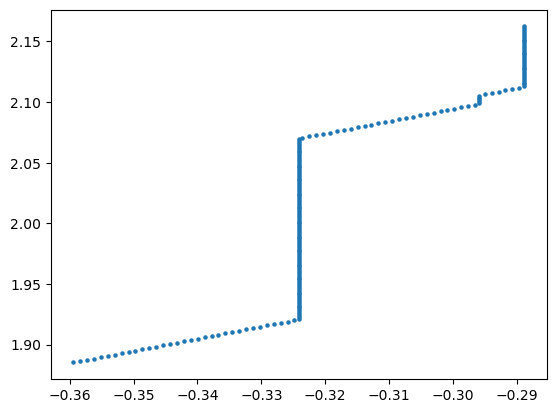

In [27]:
zx = pd.read_csv('out_chart3d/1_xoz_zx.csv')
x = zx['x']
z = zx['z']
plt.scatter(x, z, s=5)
